# Implementation and evaluation of a Collaborative-Filtering, Matrix-Factoring Recommender System based on a Bernoulli Distribution model

## Introduction
In this Jupyter Notebook the practical aspect of this Senior Project can be found. As is common in all ML projects, the following rough structure will be followed:

1. Raw data loading
2. Raw data inspection and initial operations
3. Data preprocessing
4. Model selection (or implementation in this case)
5. Model training
6. Model evaluation
7. Model export


### Disclaimer
An extra step, synthetic data generation, must be added as well after data preprocessing is complete in order to have enough data for a successful training of the model. The original dataset has only a few hundred entries, whereas several thousand, or even millions, are usually required for most applications. This **will** delude the original ratings and is only a temporary solution until enough data can be provided.

Therefore, **all results present here do not have real-world value, and evaluation metrics may seem worse than they would be in a production environment. This is fine, the usefulness of the model is not at question (proven by the paper used as basis for this project), the aim is to provide a product the end-client can use in the future.**

All the data preprocessing is purely for understanding the situation and data present and for *cold start* resolution. In the end, any data that isn't pure ratings and user or item identification will be scrapped before being fed to the model, which will derive its own factors upon which to predict results.

Finally, a lof of the code is commented out. **This was done on purpose for efficiency reasons**. If you desire to recalculate values, use different data, or simply check the executions are correct, feel free to do so but be warned it may take a long time depending on the hardware of the device it is run on.

## Raw data loading

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

columns = [
    'id', 'creationDate', 'categoryID', 'serviceType (repeating vs one-time)',
    'startDate', 'endDate', 'workAreaID', 'zipCode',
    'serviceDuration (minutes)', 'servicePrice (cents)', 'clientID',
    'clientRegisterDate', 'clientDeviceBrand', 'clientDeviceModel',
    'clientDeviceSOVersion', 'professionalID', 'professionalRegisterDate',
    'professionalRating5', 'professionalRating4', 'professionalRating3',
    'professionalRating2', 'professionalRating1', 'professionalScore',
    'rating', 'commented'
]
seed = 538 # Chosen at random. Changing this will affect result replicability
np.random.seed(seed)
random.seed(seed)
output_dir = "output/"

In [ ]:
df = pd.read_csv("data/data.csv", sep=";", names=columns)

## Raw data inspection and initial operations

Right off the bat we observe some columns that can easily be dropped, since they don't bring any value, whether because they are purely internal (such as `id`, `professionalScore`), because they are hidden to the user or don't give any value when it comes to predicting which professional a user is more likely to hire (`clientRegisterDate`, `clientDeviceBrand`...), or simply because they can be inferred from other columns (`endDate`).

In [64]:
columns_to_drop = [
    "id", "creationDate", "endDate", "clientRegisterDate", 
    "professionalRegisterDate", "professionalScore",
    "clientDeviceBrand", "clientDeviceModel", "clientDeviceSOVersion"
]
df = df.drop(columns=columns_to_drop)

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
df.dtypes

As can be observed, some data types have not been correctly inferred or can be optimised, such as `rating` (which we know can go from 1 to 5 stars), so that would be the first step.

In [ ]:
df["rating"] = pd.to_numeric(df["rating"], downcast='integer')
df = df.astype({"serviceType (repeating vs one-time)": bool, "zipCode": str})
df = df.convert_dtypes()
df.startDate = df.startDate.str.replace("T00:00:00.000Z", "")
df.dtypes

In [ ]:
df.describe()

In [ ]:
df

## Data preprocessing

The dataset is clearly biased towards the 5-star ratings. This is a behaviour commonly seen in many products, where most users will tend to rate it either extremely well (4 or 5 stars) or extremely poorly (1 or 2 stars), and those who are simply content with it don't have strong opinions and thus don't communicate them through a rating. The resulting histogram is, in a way, completely opposite to the Gaussian or Normal distribution which one would normally observe from a human behaviour due to the friction point having to write a review signifies.

In [132]:
def set_tick_size(ax, size):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(size)  
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(size)

def set_title_and_labels(title: str, x_label: str, y_label: str):
    plt.title(title, fontsize = 20)
    plt.xlabel(x_label, fontsize = 15)
    plt.ylabel(y_label, fontsize = 15)

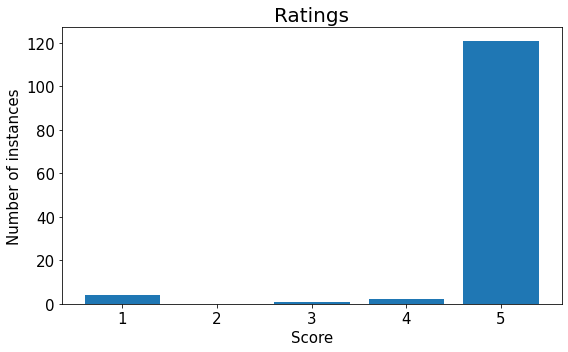

In [134]:
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(1,6, dtype='int')
plt.bar(index, [df.rating[df.rating == score].count() for score in [1,2,3,4,5]])
set_title_and_labels('Ratings', 'Score', 'Number of instances')
set_tick_size(ax, 15)

plt.tight_layout()
plt.show()

There are also a few categories that are clear user favourites (for the sake of privacy, we don't know the actual names):

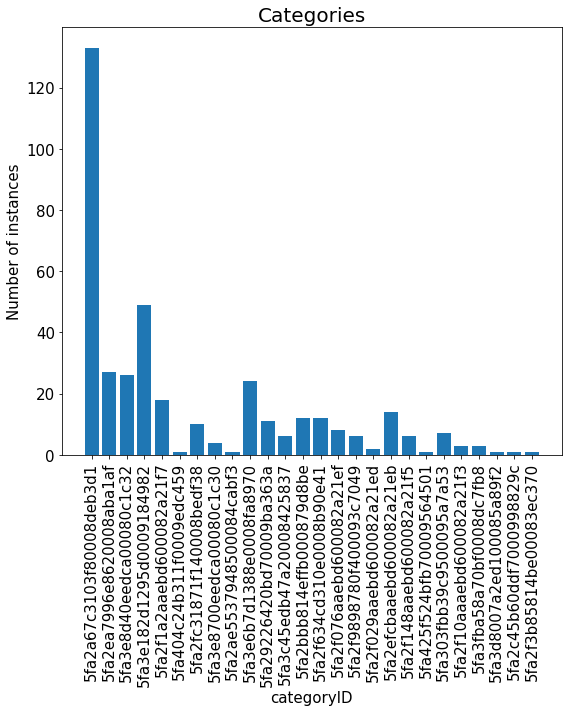

In [135]:
fig, ax = plt.subplots(figsize=(8,10))
plt.bar(df.categoryID.unique(), [df.categoryID[df.categoryID == categoryID].count() for categoryID in df.categoryID.unique()])
set_title_and_labels('Categories', 'categoryID', 'Number of instances')
plt.xticks(rotation=90)
set_tick_size(ax, 15)

plt.tight_layout()
plt.show()

As well as some areas that see more demand than others:

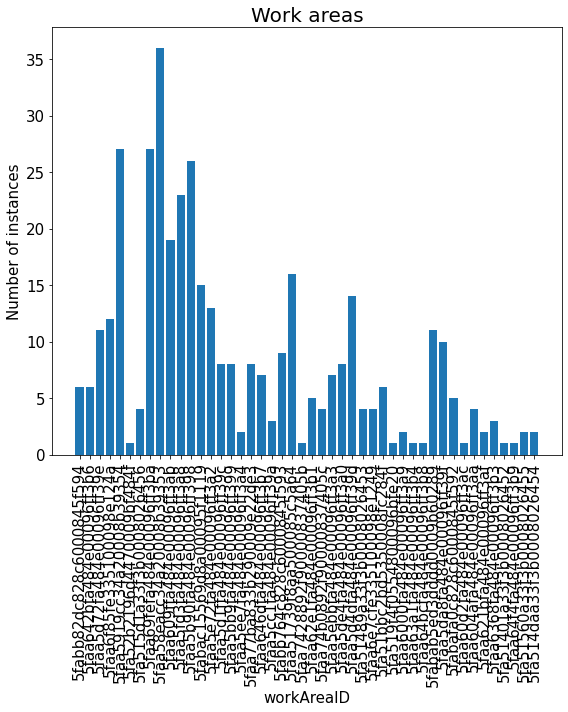

In [131]:
fig, ax = plt.subplots(figsize=(8,10))
plt.bar(df.workAreaID.unique(), [df.workAreaID[df.workAreaID == workAreaID].count() for workAreaID in df.workAreaID.unique()])
plt.xlabel('workAreaID', fontsize=15)
plt.ylabel('Number of instances', fontsize=15)
plt.title('Work areas', fontsize=20)
plt.xticks(rotation=90)
set_tick_size(ax, 15)

plt.tight_layout()
plt.show()

In [75]:
print(df.workAreaID.nunique())
print(df.zipCode.nunique())

print(df.clientID.nunique())
print(df.professionalID.nunique())

46
77
185
141


After observing the data, there doesn't seem to be any need for further preprocessing or preparation, and thus we'll continue with synthetic data generation.

## Synthetic data generation

For this purpose a manual implementation choosing random values of the existing rows has been chosen. This way, we aim to preserve the original distributions and only play with the possible combinations of existing data.

Note that this is only done in order to test the model's correct functioning, and as previously mentioned, a real dataset should be employed to obtain reliable results. In our case the dataset has only hundreds of records, which would not be enough to properly train the model and therefore we require synthetic data for a more reliable POC.

In [76]:
from numpy.random import choice
import datetime, re, math
import string

def random_date(min_date, max_date):
    time_between_dates = max_date - min_date
    random_date = min_date + datetime.timedelta(
        days=random.randrange(time_between_dates.days))
    return random_date

def random_work_area_and_zip_code(max_index):
    row = choice(max_index)
    return (df["workAreaID"][row], df["zipCode"][row])

def calculate_rating_deviation(std, choices):
    """
    Calculates a random integer to add or subtract based on the given standard deviation and choices
    """
    return choice([-1, 1]) * (1 if std <= 0.5 else round(choice(choices) * std))

def get_common_variables():
    synthetic_df = pd.DataFrame(columns=df.columns)
    std_choices = [0.1, 0.25, 0.5, 0.75, 1]
    std_values = {
        "1": df.professionalRating1.std(),
        "2": df.professionalRating2.std(),
        "3": df.professionalRating3.std(),
        "4": df.professionalRating4.std(),
        "5": df.professionalRating5.std()
    }
    minimum_date = datetime.date(2021, 1, 1)
    maximum_date = datetime.date.today()
    max_posible_row = len(df) - 1
    
    return (synthetic_df, std_choices, std_values, minimum_date, maximum_date, max_posible_row)


def generate_synthetic_data(mode: str, number_of_samples: int, number_of_users = None, number_of_professionals = None):
    """
    Rules:
        - workAreaID has to match the correct zipCode, therefore it obtains both workAreaID and zipCode from the same row
        - For professionalRatingX it uses an entire row, and adds or subtracts 10%, 25%, 50%, 75% or 100% of the std for that feature (round to closest int).
            * If std is <= 0.5, then randomly adds or subtracts 1
            * professionalRatingX is never <0
    """
    if mode == "new":
        return generate_synthetic_data_with_new_IDs(number_of_samples, number_of_users, number_of_professionals)
    return generate_synthetic_data_with_existing_IDs(number_of_samples)


def generate_synthetic_data_with_new_IDs(number_of_samples, number_of_users, number_of_professionals):
    synthetic_df, std_choices, std_values, minimum_date, maximum_date, max_posible_row = get_common_variables()
    
    synthetic_user_ids = sorted(["".join(random.choice("0123456789abcdef") for _ in range(24)) for _ in range(number_of_users)])
    synthetic_professional_ids = sorted(["".join(random.choice("0123456789abcdef") for _ in range(24)) for _ in range(number_of_professionals)])
    work_area_zip_code_assignation = {id: random_work_area_and_zip_code(max_posible_row) for id in synthetic_professional_ids}
    
    new_rows_list = []
    for _ in range(number_of_samples):
        new_row = {}
        for column in df.columns:
            if column == "zipCode" or column == "workAreaID" or re.match("^professionalRating[2-9]$", column):
                continue

            row = choice(max_posible_row)
            if column == "clientID":
                new_row[column] = choice(synthetic_user_ids)
                continue
            if column == "professionalID":
                professional_id = choice(synthetic_professional_ids)
                new_row[column] = professional_id
                new_row["workAreaID"], new_row["zipCode"] = work_area_zip_code_assignation[professional_id]
                continue
            if column == "startDate":
                new_row[column] = choice([random_date(minimum_date, maximum_date).strftime("%Y-%m-%d"), df[column][row]])
                continue
            if column == "professionalRating1":
                new_row[column] = max(df[column][row] + calculate_rating_deviation(std_values["1"], std_choices), 0)
                for index in range(2,6):
                    column_name = f"professionalRating{index}"
                    new_row[column_name] = max(df[column_name][row] + calculate_rating_deviation(std_values[f"{index}"], std_choices), 0)
                continue
            if column == "rating":
                new_row[column] = df[column][row] if pd.notna(df[column][row]) else None
                continue
            new_row[column] = df[column][row]
        new_rows_list.append(new_row)
    synthetic_df = synthetic_df.append(new_rows_list, ignore_index=True)
    return synthetic_df


def generate_synthetic_data_with_existing_IDs(number_of_samples):
    synthetic_df, std_choices, std_values, minimum_date, maximum_date, max_posible_row = get_common_variables()
    
    new_rows_list = []
    for _ in range(number_of_samples):
        new_row = {}
        for column in df.columns:
            if column == "zipCode" or re.match("^professionalRating[2-9]$", column):
                continue

            row = choice(max_posible_row)
            if column == "rating":
                new_row[column] = df[column][row] if pd.notna(df[column][row]) else None
                continue
            if column == "workAreaID":
                new_row[column] = df[column][row]
                new_row["zipCode"] = df["zipCode"][row]
                continue
            if column == "startDate":
                new_row[column] = choice([random_date(minimum_date, maximum_date).strftime("%Y-%m-%d"), df[column][row]])
                continue
            if column == "professionalRating1":
                for i in range(1,6):
                    column = f"professionalRating{i}"
                    new_row[column] = max(df[column][row] + calculate_rating_deviation(std_values[f"{i}"], std_choices), 0)
                continue
            new_row[column] = df[column][row]
        new_rows_list.append(new_row)
    synthetic_df = synthetic_df.append(new_rows_list, ignore_index=True)
    return synthetic_df

We'll generate a dataset comprised of 25000 synthetic interactions among the existing users if using `ids_mode = "existing"` (and among synthetic users and professionals if using `ids_mode = "new"`), based on the provided data. We obtain the following results:

In [77]:
%%time
synthetic_samples = 25000
ids_mode = "existing" # ["existing", "new"]
number_of_user_IDs = 700
number_of_professional_IDs = 600


# Uncomment to generate the synthetic data
# synthetic_df = generate_synthetic_data(ids_mode, synthetic_samples, number_of_user_IDs, number_of_professional_IDs)

# Uncomment to use precalculated version
synthetic_df = pd.read_csv(f"{output_dir}synthetic_df_{ids_mode}_IDs.csv")

user_ids = synthetic_df.clientID.unique()
professional_ids = synthetic_df.professionalID.unique()

Wall time: 90 ms


In [ ]:
print(synthetic_df.shape)
print(synthetic_df.columns)
# There shouldn't be any more workAreas, zipCodes, clientIDs or professionalIDs than before
print(synthetic_df.workAreaID.nunique()) # <= 46
print(synthetic_df.zipCode.nunique()) # <= 77

print(synthetic_df.clientID.nunique()) # <= 185
print(synthetic_df.professionalID.nunique()) # <= 141

In [ ]:
synthetic_df

In [ ]:
synthetic_df.dtypes

In [ ]:
synthetic_df = synthetic_df.astype({"serviceType (repeating vs one-time)": bool, "zipCode": str})
synthetic_df = synthetic_df.convert_dtypes()
synthetic_df.rating = pd.to_numeric(synthetic_df.rating, downcast='integer')
synthetic_df.dtypes

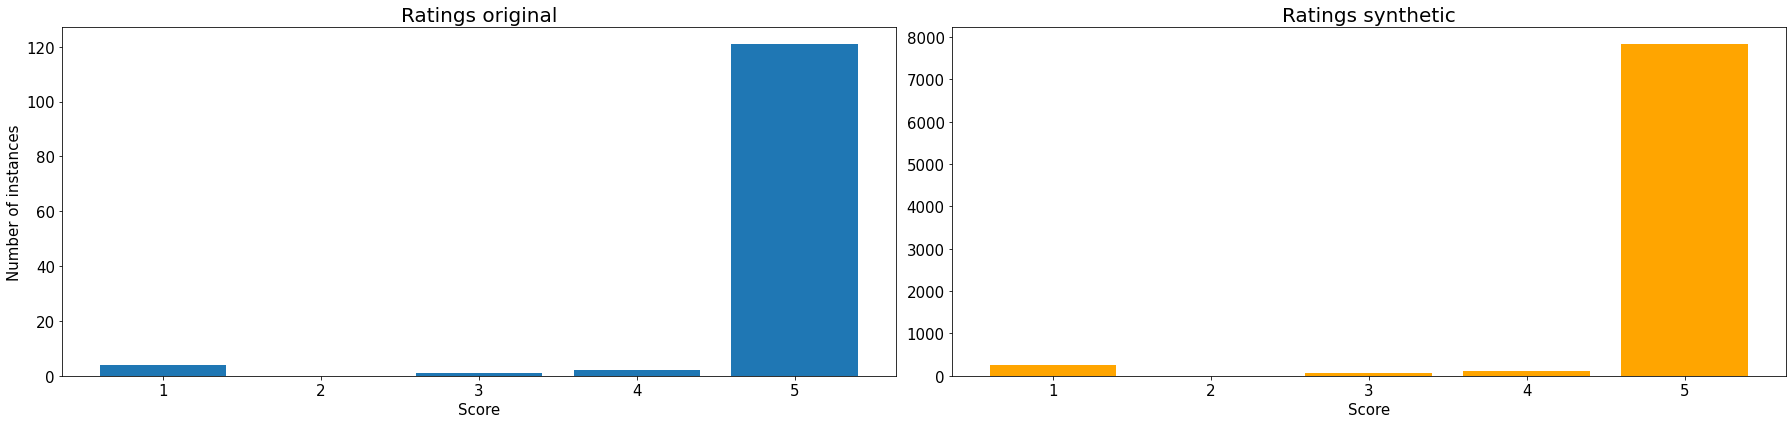

In [137]:
fig, ax = plt.subplots(ncols=2, figsize=(25,6))
index = np.arange(1,6, dtype='int')

plt.subplot(1,2,1)
plt.bar(index, [df.rating[df.rating == score].count() for score in [1,2,3,4,5]])
set_title_and_labels('Ratings original','Score','Number of instances')
set_tick_size(ax[0], 15)

plt.subplot(1,2,2)
plt.bar(index, [synthetic_df.rating[synthetic_df.rating == score].count() for score in [1,2,3,4,5]], color='orange')
set_title_and_labels('Ratings synthetic','Score','')
set_tick_size(ax[1], 15)

plt.tight_layout()
plt.show()

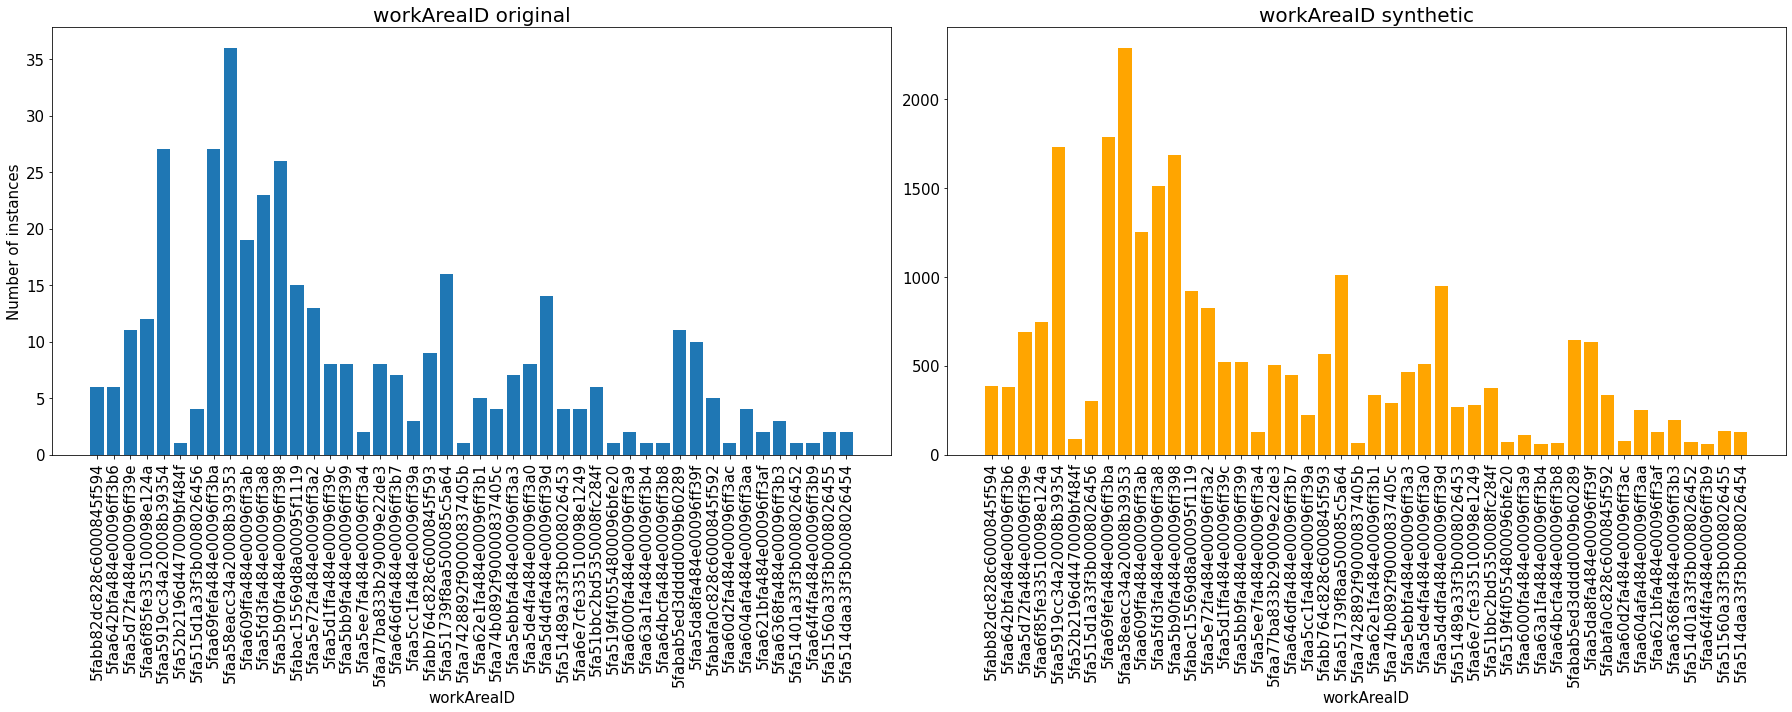

In [123]:
fig, ax = plt.subplots(ncols=2, figsize=(25,10))
plt.subplot(1,2,1)
plt.bar(df.workAreaID.unique(), [df.workAreaID[df.workAreaID == workAreaID].count() for workAreaID in df.workAreaID.unique()])
plt.xlabel('workAreaID', fontsize=15)
plt.ylabel('Number of instances', fontsize=15)
plt.title('workAreaID original', fontsize=20)
plt.xticks(rotation=90)
set_tick_size(ax[0], 15)

plt.subplot(1,2,2)
plt.bar(df.workAreaID.unique(), [synthetic_df.workAreaID[synthetic_df.workAreaID == workAreaID].count() for workAreaID in df.workAreaID.unique()], color='orange')
plt.xlabel('workAreaID', fontsize=15)
plt.title('workAreaID synthetic', fontsize=20)
plt.xticks(rotation=90)
set_tick_size(ax[1], 15)

plt.tight_layout()
plt.show()

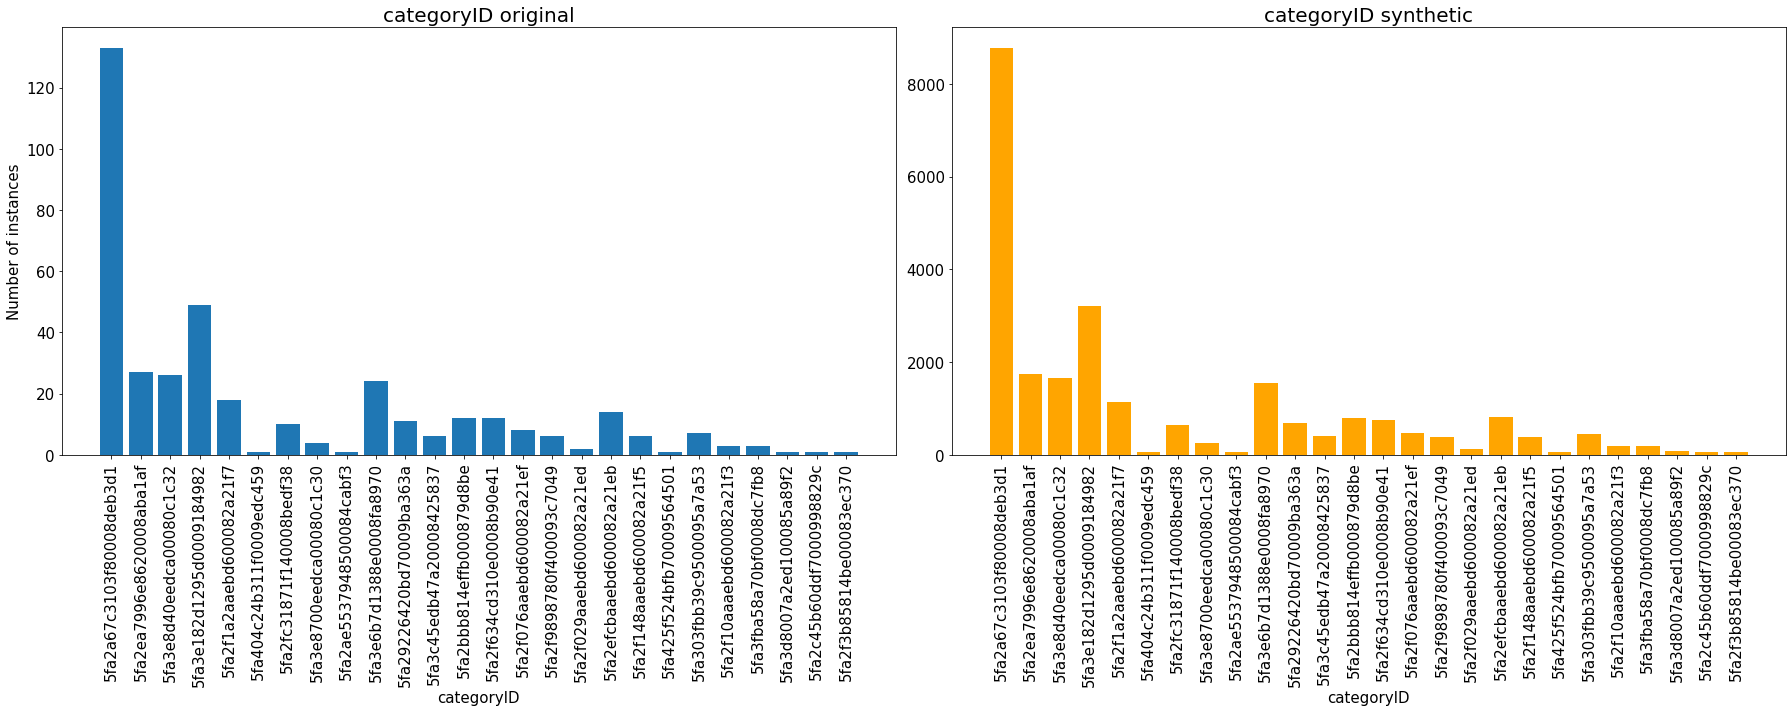

In [125]:
fig, ax = plt.subplots(ncols=2, figsize=(25,10))

plt.subplot(1,2,1)
plt.bar(df.categoryID.unique(), [df.categoryID[df.categoryID == categoryID].count() for categoryID in df.categoryID.unique()])
plt.xlabel('categoryID', fontsize=15)
plt.ylabel('Number of instances', fontsize=15)
plt.title('categoryID original', fontsize=20)
plt.xticks(rotation=90)
set_tick_size(ax[0], 15)

plt.subplot(1,2,2)
plt.bar(df.categoryID.unique(), [synthetic_df.categoryID[synthetic_df.categoryID == categoryID].count() for categoryID in df.categoryID.unique()], color='orange')
plt.xlabel('categoryID', fontsize=15)
plt.title('categoryID synthetic', fontsize=20)
plt.xticks(rotation=90)
set_tick_size(ax[1], 15)

plt.tight_layout()
plt.show()

In [ ]:
df.describe()

In [ ]:
synthetic_df.describe()

In [25]:
# Uncomment to save to .csv
# synthetic_df.to_csv(f"{output_dir}synthetic_df_{ids_mode}_IDs.csv", index=False)

As can be observed, the data distributions are all kept the same or very similar with the exception of `professionalRating1-5` (since extra votes were added in order to simulate a more realistic situation) and `workAreaID` (since professionals were assigned to them at random but preserving the `zipCode` they belong to), yet we now have a much larger dataset which the model can more easily learn from.

The next step is to derive the User-Item-Rating matrix to be used by the model itself to derive factors and learn from the interactions. As previously mentioned, all columns but the `clientID`, `professionalID` and `rating` will be removed to achieve this.

Since a user can rate the same professional twice, either the latest rating or an average rating can be used.

### Numeric ratings

In [38]:
def get_rating(df: pd.DataFrame, user_id: str, item_id: str, mode: str = "average"):
    rating_series = df[(df["clientID"] == user_id) & (df["professionalID"] == item_id)].rating
    if mode == "last_rating":
        return rating_series.iloc[-1] if len(rating_series.index) != 0 and not pd.isna(rating_series) else None
    mean = rating_series.mean()
    return round(mean) if len(rating_series.index) != 0 and not pd.isna(mean) else None


def save_matrix_to_csv(matrix, output_name: str):
    print(f"Exporting DataFrame to {output_dir}{output_name} with shape {matrix.shape}")
    pd.DataFrame(matrix).to_csv(f"{output_dir}{output_name}", index=False)


# For testing purposes
# %timeit get_rating(synthetic_df, "5b9a59ff6baffc3b03487291", "9588cd3034a657cabdb020fc")
# print(ids_mode)
# if ids_mode == "existing":
#     print(get_rating(synthetic_df, "60675ce94d13240008470c7c", "601814e4d0d43b000d6ee2be")) # 5
# elif ids_mode == "new":
#     print(get_rating(synthetic_df, "5b9a59ff6baffc3b03487291", "9588cd3034a657cabdb020fc")) # 1

In [27]:
# %%time
# Uncomment to generate the training ratings matrix
# train_ratings_matrix = np.array([np.array([get_rating(synthetic_df, user_id, item_id) for item_id in professional_ids]) for user_id in user_ids])
# print(train_ratings_matrix.shape)

# Uncomment to save the matrix for faster access
# save_matrix_to_csv(train_ratings_matrix, f"Ratings-{ids_mode}_IDs_{int(synthetic_samples/1000)}K.csv")

In [28]:
# Uncomment to use precalculated version
train_ratings_matrix = np.array(pd.read_csv(f"{output_dir}Ratings-{ids_mode}_IDs_{int(synthetic_samples/1000)}K.csv").to_numpy())
print(train_ratings_matrix.shape)

(184, 141)


In [40]:
# %%time
# Uncomment to generate the test ratings matrix
# test_ratings_matrix = np.array([np.array([get_rating(df, user_id, item_id) for item_id in df.professionalID.unique()]) for user_id in df.clientID.unique() if user_id in user_ids])
# print(test_ratings_matrix.shape)

# Uncomment to save the matrix for faster access
# save_matrix_to_csv(test_ratings_matrix, "test_ratings.csv")

(184, 141)
Exporting DataFrame to output/test_ratings.csv with shape (184, 141)


In [43]:
test_ratings_matrix = np.array(pd.read_csv(f"{output_dir}test_ratings.csv").fillna(0).to_numpy())
print(test_ratings_matrix.shape)

(184, 141)


## Model implementation
The BeMF model was already implemented in Java by one of its authors, Fernando Ortega, so that code was used as the base for the translation into Python. For simplicity's sake, it will be imported as a module, but the code is avalaible in `./Code/BeMF.py`

## Model training

In [31]:
# Naive/Simple approach
from Code.BeMF import BeMF

model = BeMF(possible_scores=[1,2,3,4,5], user_item_rating_matrix=train_ratings_matrix, user_ids=user_ids,
           item_ids=professional_ids, num_factors=10, num_iters=100, learning_rate=0.05, regularisation=0.05, seed=seed)
print(model)

*BeMF model setup completed*
num_factors:	10
num_iters:	150
learning_rate:	0.05
regularisation:	0.05
possible_scores:	[1, 2, 3, 4, 5]
user_ids:	184
item_ids:	141
ratings:	(184, 141)
U:	(5, 184, 10)
V:	(5, 141, 10)


In [32]:
%%time
model.fit(verbose=True)

Starting fitting process. Please wait.
........	10 iterations - MAE: 4.015417823003393
.........	20 iterations - MAE: 3.980188097440641
.........	30 iterations - MAE: 3.793285538082023
.........	40 iterations - MAE: 3.8455519580635213
.........	50 iterations - MAE: 3.9251850138760407
.........	60 iterations - MAE: 3.5952821461609625
.........	70 iterations - MAE: 3.8494064138143687
.........	80 iterations - MAE: 3.947039777983349
.........	90 iterations - MAE: 3.880627505396238
.........	100 iterations - MAE: 3.4906336725254397
.........	110 iterations - MAE: 3.691296638914585
.........	120 iterations - MAE: 4.0134135060129505
.........	130 iterations - MAE: 3.603607770582794
.........	140 iterations - MAE: 3.7435630588960835
.........	150 iterations - MAE: 3.8038082022818385
Training concluded
Wall time: 6min 20s


In [33]:
# Model testing
# for i in range(25):
#     chosen_user = choice(synthetic_df.clientID.nunique())
#     chosen_item = choice(synthetic_df.professionalID.nunique())
#     print(f"user {chosen_user} & item {chosen_item}")
#     print(f"\tProbabilities: {[model.get_probability(chosen_user, chosen_item, i) for i in range(5)]}")
#     print(f"\tPrediction: {model.predict(user_index=chosen_user, item_index=chosen_item)} stars with {model.predict_proba(user_index=chosen_user, item_index=chosen_item)*100}% confidence")
#     print()

As the model has 4 hyperparameters (`num_factors`, `num_iters`, `learning_rate`, `regularisation`) we'll use a GridSearch approach to find the best ones instead of using random ones.

Since `sklearn`'s implementation requires conformance to certain interfaces, it'll be performed manually.

In [34]:
def generate_grid_search_models(param_grid: {}):
    """Instantiates a new BeMF model for each combination of hyperparameters provided in `param_grid`
    """
    return {
        f"f{num_factors} i{num_iters} l{learning_rate} r{regularisation}": BeMF(possible_scores=[1,2,3,4,5],
                                                                             user_item_rating_matrix=train_ratings_matrix,
                                                                             user_ids=user_ids,
                                                                             item_ids=professional_ids,
                                                                             num_factors=num_factors,
                                                                             num_iters=num_iters,
                                                                             learning_rate=learning_rate,
                                                                             regularisation=regularisation,
                                                                             seed=seed,
                                                                             verbose = False)
        for regularisation in param_grid["regularisation"]
        for learning_rate in param_grid["learning_rate"]
        for num_iters in param_grid["num_iters"]
        for num_factors in param_grid["num_factors"]
    }


def find_best_model(model_dict: {}):
    """Fits each model in the dictionary and returns a tuple containing the one with the lowest MAE and its MAE
    """
    best_MAE = math.inf
    best_model = None
    for parameters, model in model_dict.items():
        print(f"\Training model {parameters}")
        model.fit()
        if not best_model:
            best_model = model
            best_MAE = model.evaluate_MAE()
            continue
        if best_MAE > model.evaluate_MAE():
            best_model = model
            best_MAE = model.evaluate_MAE()
    return (best_model, best_MAE, parameters)


def grid_search(param_grid):
    """Performs a GridSearch based on the parameters given
    """
    return find_best_model(generate_grid_search_models(param_grid))

In [ ]:
%%time
"""First iteration:
param_grid = {
    "num_factors": [10, 20, 30],
    "num_iters": [100],
    "learning_rate": [0.001, 0.01, 0.1],
    "regularisation": [0.001, 0.01, 0.1]
}

Assuming best model was 20, 100, 0.1, 0.01, then:
Second iteration
param_grid = {
    "num_factors": [15, 20, 25],
    "num_iters": [100],
    "learning_rate": [0.05, 0.1, 0.15],
    "regularisation": [0.005, 0.01, 0.15]
}

It is recommened to perform at least 2 or 3 iteration
"""
param_grid = {
    "num_factors": [10, 20, 30],
    "num_iters": [100],
    "learning_rate": [0.001, 0.01, 0.1],
    "regularisation": [0.001, 0.01, 0.1]
}
best_model, best_MAE, best_model_id = grid_search(param_grid)

## Model evaluation

The $MAE$, $Precision$, $Recall$ and $Coverage$ metrics will be used, although any other candidate deemed suitable can be used as well. The model deemed as "best" is decided upon its $MAE$ score. This is a decision subject to change which ultimately depends on the company's goal.

In [57]:
from sklearn.metrics import precision_score, recall_score

def precision_and_recall(y_true, y_pred, average: str):
    precision_sum = 0
    recall_sum = 0
    for user_index in range(len(user_ids)):
        precision_sum += precision_score(y_true[user_index], y_pred[user_index], average=average, zero_division=0)
        recall_sum += recall_score(y_true[user_index], y_pred[user_index], average=average, zero_division=0)
    return (precision_sum/len(user_ids), recall_sum/len(user_ids))
        

def coverage(y_pred, threshold: int):
    coverage_sum = 0
    """Calculates the coverage (total items recommended/total items available) given a minimum predicted score (threshold) for all users"""
    for user_index in range(len(user_ids)):
        predictions_for_current_user = np.array(y_pred[user_index])
        coverage_sum += np.sum(np.where(predictions_for_current_user >= threshold, 1, 0))/len(predictions_for_current_user)
    return coverage_sum/len(user_ids)

threshold = 3
coverage = coverage(best_model.predictions_matrix, threshold)
precision, recall = precision_and_recall(test_ratings_matrix, best_model.predictions_matrix, 'macro')

# print(f"MAE (lower is better): {best_MAE}")
print(f"Precision:\t{precision} (higher is better)")
print(f"Recall:\t\t{recall} (higher is better)")
print(f"Coverage ({threshold}):\t{coverage} (1 = all items offered, 0 = none items offered)")

Precision:	0.001324653167152607 (higher is better)
Recall:	0.0919384057971015 (higher is better)
Coverage (threshold 3): 1.0 (1 = all items offered, 0 = none items offered)


## Model export

In [1]:
import pickle

model_filename = f"{output_dir}Trained-BeMF-Model{best_model_id}.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
    print(f"Succesfully saved the model to {model_filename}")

# To load the model simply copy and paste this code
# with open(model_filename, 'rb') as file: # Make sure to match the filename and point to correct path
#     model = pickle.load(file)
#     print(f"Succesfully loaded model {model}")